<a href="https://colab.research.google.com/github/david-levin11/alaska_verification/blob/main/PlotHiRes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Objective: To plot archived high resolution model data for AK**
<br/>
Description--This script will attempt to use the Herbie python package to download and plot archived hi-resolution model data for case reviews/operational recaps.

The available models are:

**AK HRRR**<br/>
**RRFS Control Run**<br/>
**NamNest**

HRRR data for Alaska is available on AWS back to 2018.  NamNest data goes back to September 2021. RRFS data is sporadic as it is an experimental model but most of the data from 2024 is available on AWS.  Sometimes runs will not be found or be incomplete.  This may cause issues especially with precipitation variables which rely on two timesteps to be available in order to plot properly.

I have the notebook set to plot only a few of the numerous variables the hi-res models output.  If there is a particular variable you would like to see plotted, feel free to let me know and I'll see if I can add it.  Alternatively you are welcome to make a copy of this notebook and play around with adding various improvements!

**Update: 9/12/2024**
--Added custom zoom areas as well as the ability to create animated gifs.  Let me know if you'd like different zooms or any other features/fields!

**Update: 4/29/2025**
--RRFS was broken **AGAIN** as the file structures on AWS are constantly changing.  Since Herbie no longer works with RRFS I updated to remove the Herbie dependency for RRFS and tried to make it smart enough to grab whatever files exist for the RRFS evaluation on the AWS S3 bucket.  It's not as many as used to be unfortunately.  Best advice is just to try your date and see if a run exists. If you can find the run on https://noaa-rrfs-pds.s3.amazonaws.com/index.html#retro_output_final/ but the script is still not plotting, please let me know.  Also if there are additional fields you'd like to see plotted for the RRFS evaluation, please contact me.  

**Update: 5/5/2025**
--RRFS repo is now missing on AWS so until it is either fixed or brought back RRFS fields will not work.  Will update as soon as more information becomes available.

**Update 5/29/2025**
--RRFS retro data is now back as are the .idx files.  I did add in a way to get the data using pygrib just in case there are missing .idx in the future but the subsetting should now work.  Also fixed an issue with the winds for the NamNest which was preventing proper display.

**Update 6/3/2025**
Added the ability to do difference plots for certain elements as well as added 80m wind for RRFS evaluation
- David Levin, Arctic Testbed & Proving Ground, Anchorage Alaska

##**1 - Install and Import Packages**
This will take about a minute to run.

In [1]:
# @title
!pip install eccodes==2.38.3 # need this version to avoid a google colab crash
!pip install herbie-data[extras]
!pip install cartopy
!pip install pygrib
!pip install scipy
from herbie import Herbie
from herbie.toolbox import EasyMap, pc
from herbie import paint
import requests
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import pandas as pd
import pygrib
from scipy import interpolate
from scipy.interpolate import RegularGridInterpolator
from scipy.interpolate import griddata
try:
    import numpy as np
    import os
    import sys
    import re
    import xarray as xr
    from datetime import datetime, timedelta
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors
except ImportError:
    raise ImportError("herbie.paint requires matplotlib.")
from PIL import Image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.3/113.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 424.3/424.3 kB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.6/18.6 MB 56.0 MB/s eta 0:00:00
 ╭─▌▌Herbie─────────────────────────────────────────────╮
 │ INFO: Created a default config file.                 │
 │ You may view/edit Herbie's configuration here:       │
 │          /root/.config/herbie/config.toml            │
 ╰──────────────────────────────────────────────────────╯



##**2 - Download & Plot**

<ipython-input-7-4d983c8f31a6>:20: UserWarning: Overwriting the cmap 'nws.pcp' that was already in the registry.
  mpl.colormaps.register(cmap=cm, force=True)
<ipython-input-7-4d983c8f31a6>:21: UserWarning: Overwriting the cmap 'nws.pcp_r' that was already in the registry.
  mpl.colormaps.register(cmap=cm.reversed(), force=True)
<ipython-input-7-4d983c8f31a6>:20: UserWarning: Overwriting the cmap 'nws.pcp2' that was already in the registry.
  mpl.colormaps.register(cmap=cm, force=True)
<ipython-input-7-4d983c8f31a6>:21: UserWarning: Overwriting the cmap 'nws.pcp2_r' that was already in the registry.
  mpl.colormaps.register(cmap=cm.reversed(), force=True)
<ipython-input-7-4d983c8f31a6>:20: UserWarning: Overwriting the cmap 'nws.pcp_snow' that was already in the registry.
  mpl.colormaps.register(cmap=cm, force=True)
<ipython-input-7-4d983c8f31a6>:21: UserWarning: Overwriting the cmap 'nws.pcp_snow_r' that was already in the registry.
  mpl.colormaps.register(cmap=cm.reversed(), force=T

Selected forecast hour range: 0 to 24
Forecast hours list: [0, 3, 6, 9, 12, 15, 18, 21, 24]
I see you've selected a custom zoom...checking your lat/lon pairs...
All domain bounds have valid values.
Working on forecast hour 0 for valid time 2024-01-22 12Z
Working on forecast hour 3 for valid time 2024-01-22 15Z
Working on forecast hour 6 for valid time 2024-01-22 18Z
Working on forecast hour 9 for valid time 2024-01-22 21Z
Working on forecast hour 12 for valid time 2024-01-23 00Z
Working on forecast hour 15 for valid time 2024-01-23 03Z
Working on forecast hour 18 for valid time 2024-01-23 06Z
Working on forecast hour 21 for valid time 2024-01-23 09Z
Working on forecast hour 24 for valid time 2024-01-23 12Z
Now working on namnest for TotalSnow
✅ Found ┊ model=nam ┊ product=alaskanest.hiresf ┊ 2024-Jan-22 12:00 UTC F24 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/root/data/nam/20240122]


/usr/local/lib/python3.11/dist-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Now working on rrfs for TotalSnow
Month is: 1
  > Downloading subset for rrfs.t12z.prslev.f024.ak.grib2
🧪 Search strings: [':ASNOW:surface:0-[1-60]*']
✅ Downloaded [1] fields → model/winter_rrfs.t12z.prslev.f024.ak.grib2


/usr/local/lib/python3.11/dist-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


Some values are NaN, but there are valid values too.
Min: -107.550705909729
Max: 31.686050415039062
Number of valid points: 1282244


/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_populated_places.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_1_states_provinces_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


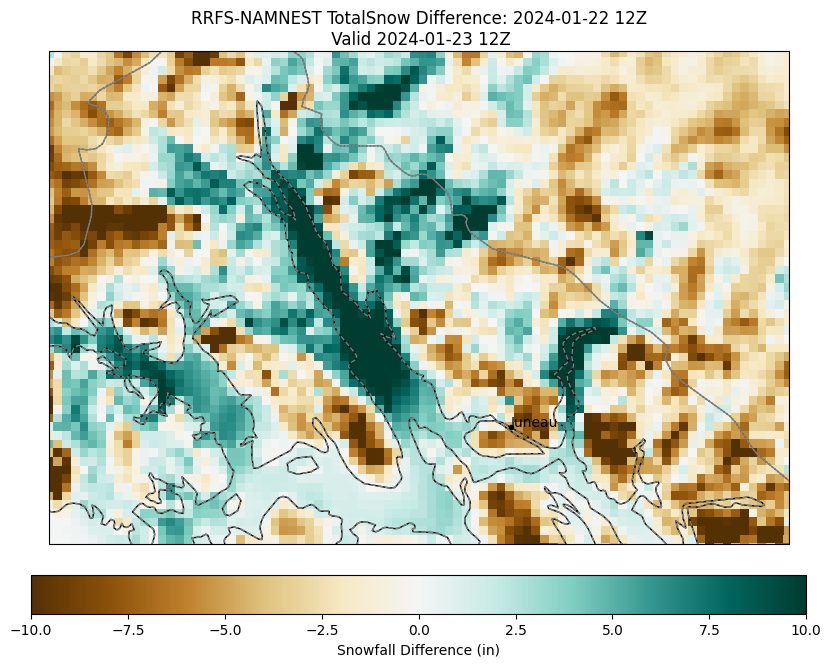

Saved Surface rrfs_namnest_TotalSnow_2024012212Z_2024012312Z.png to /nas/hires/graphics
Creating animation...
You don't have enough images for a loop...sorry!


In [7]:
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch
import cfgrib

###################### Classes for Colormaps ##################################
# setting up our colorscales for plotting precip since Herbie only uses mm    #
# can use paint for everything else                                           #
###############################################################################
def make_custom_cmaps(name, colors, bounds: list = None, N: int = None):
    if N is None:
        N = len(colors)
    linear_cmap = mcolors.LinearSegmentedColormap.from_list(name, colors)
    segment_cmap = mcolors.LinearSegmentedColormap.from_list(name + "2", colors, N=N)

    # When data is NaN, set color to transparent
    linear_cmap.set_bad("#ffffff00")
    segment_cmap.set_bad("#ffffff00")

    for cm in [linear_cmap, segment_cmap]:
        mpl.colormaps.register(cmap=cm, force=True)
        mpl.colormaps.register(cmap=cm.reversed(), force=True)

    if bounds is not None:
        return (
            mcolors.Normalize(bounds.min(), bounds.max()),
            mcolors.BoundaryNorm(bounds, linear_cmap.N),
        )

class NWSPrecipitation:
    """National Weather Service precipitation amount colorbar properties.

    Also known as Qualitative Precipitation Forecast/Estimate (QPF/QPE).
    """

    name = "nws.pcp"
    units = "in"
    variable = "Precipitation"
    colors = np.array(
        [
            "#ffffff",
            "#c7e9c0",
            "#a1d99b",
            "#74c476",
            "#31a353",
            "#006d2c",
            "#fffa8a",
            "#ffcc4f",
            "#fe8d3c",
            "#fc4e2a",
            "#d61a1c",
            "#ad0026",
            "#700026",
            "#3b0030",
            "#4c0073",
            "#ffdbff",
        ]
    )
    # NWS bounds in inches
    bounds = np.array(
        [0, 0.01, 0.1, 0.25, 0.5, 1, 1.5, 2, 3, 4, 6, 8, 10, 15, 20, 30, 50]
    )
    norm, norm2 = make_custom_cmaps(name, colors, bounds)
    cmap = plt.get_cmap(name)
    cmap2 = plt.get_cmap(name + "2")
    kwargs = dict(cmap=cmap, norm=norm)
    kwargs2 = dict(cmap=cmap, norm=norm2)
    cbar_kwargs = dict(label=f"{variable} ({units})")
    cbar_kwargs2 = cbar_kwargs | dict(spacing="uniform", ticks=bounds)

class NWSPrecipitationSnow:
    name = "nws.pcp_snow"
    units = "in"
    variable = "Snow"
    colors = np.array(
        [
            "#ffffff",
            "#bdd7e7",
            "#6baed6",
            "#3182bd",
            "#08519c",
            "#082694",
            "#ffff96",
            "#ffc400",
            "#ff8700",
            "#db1400",
            "#9e0000",
            "#690000",
            "#360000",
        ]
    )
    # NWS bounds in inches
    bounds = np.array([0, 0.1, 1, 2, 3, 4, 6, 8, 12, 18, 24, 30, 36, 42])
    norm, norm2 = make_custom_cmaps(name, colors, bounds)
    cmap = plt.get_cmap(name)
    cmap2 = plt.get_cmap(name + "2")
    kwargs = dict(cmap=cmap, norm=norm)
    kwargs2 = dict(cmap=cmap, norm=norm2)
    cbar_kwargs = dict(label=f"{variable} ({units})")
    cbar_kwargs2 = cbar_kwargs | dict(spacing="uniform", ticks=bounds)

class NWSWindSpeed:
    name = "nws.wind"
    units = r"mph"
    variable = "Wind Speed"
    colors = np.array(
        [
            "#103f78",
            "#225ea8",
            "#1d91c0",
            "#41b6c4",
            "#7fcdbb",
            "#b4d79e",
            "#dfff9e",
            "#ffffa6",
            "#ffe873",
            "#ffc400",
            "#ffaa00",
            "#ff5900",
            "#ff0000",
            "#a80000",
            "#6e0000",
            "#ffbee8",
            "#ff73df",
        ]
    )
    # MPH
    bounds = np.array(
        [0.0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 100, 120, 140, 160]
    )
    norm, norm2 = make_custom_cmaps(name, colors, bounds)
    cmap = plt.get_cmap(name)
    cmap2 = plt.get_cmap(name + "2")
    kwargs = dict(cmap=cmap, norm=norm)
    kwargs2 = dict(cmap=cmap, norm=norm2)
    cbar_kwargs = dict(label=f"{variable} ({units})")
    cbar_kwargs2 = cbar_kwargs | dict(spacing="proportional", ticks=bounds)

class NWSWindSpeedkts:
    name = "nws.wind"
    units = r"kts"
    variable = "Wind Speed"
    colors = np.array(
        [
            "#103f78",
            "#225ea8",
            "#1d91c0",
            "#41b6c4",
            "#7fcdbb",
            "#b4d79e",
            "#dfff9e",
            "#ffffa6",
            "#ffe873",
            "#ffc400",
            "#ffaa00",
            "#ff5900",
            "#ff0000",
            "#a80000",
            "#6e0000",
            "#ffbee8",
            "#ff73df",
        ]
    )
    # kts
    bounds = np.array(
        [0.0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 100, 120, 140, 160]
    )
    norm, norm2 = make_custom_cmaps(name, colors, bounds)
    cmap = plt.get_cmap(name)
    cmap2 = plt.get_cmap(name + "2")
    kwargs = dict(cmap=cmap, norm=norm)
    kwargs2 = dict(cmap=cmap, norm=norm2)
    cbar_kwargs = dict(label=f"{variable} ({units})")
    cbar_kwargs2 = cbar_kwargs | dict(spacing="proportional", ticks=bounds)

def plot_towns(ax, south, north, west, east, population=5000, resolution='10m', transform=ccrs.PlateCarree(), zorder=3):
    """
    This function will download the 'populated_places' shapefile from
    NaturalEarth, trim the shapefile based on the limits of the provided
    lat & long coords, and then plot the locations and names of the towns
    on a given GeoAxes.

    ax = a pyplot axes object
    south = south lat limit (float)
    north = north lat limit (float)
    west = west long limit (float)
    east = east long limit (float)
    resolution= str. either high res:'10m' or low res: '50m'
    population = minimum population of towns to plot (int)
    transform = a cartopy crs object
    """
    #get town locations
    shp_fn = shpreader.natural_earth(resolution=resolution, category='cultural', name='populated_places')
    shp = shpreader.Reader(shp_fn)
    xy = [pt.coords[0] for pt in shp.geometries()]
    x, y = list(zip(*xy))

    #get town names
    towns = shp.records()
    names_en = []
    max_population = []
    for town in towns:
        #print(town.attributes)
        names = town.attributes['NAME']
        pop = town.attributes['POP_MAX']
        names_en.append(names)
        max_population.append(pop)
    #print(names_en)
    #create data frame and index by the region of the plot
    all_towns = pd.DataFrame({'names_en': names_en, 'x':x, 'y':y, 'population':max_population})
    #print(all_towns.head())
    region_towns = all_towns[(all_towns.y<north) & (all_towns.y>south)
                           & (all_towns.x>west) & (all_towns.x<east)]
    region_towns = region_towns[region_towns.population > population]
    #print(region_towns.head())
    #plot the locations and labels of the towns in the region
    ax.scatter(region_towns.x.values, region_towns.y.values, c ='black', marker= '.', transform=transform, zorder=zorder)
    transform_mpl = ccrs.PlateCarree()._as_mpl_transform(ax) #this is a work-around to transform xy coords in ax.annotate
    for i, txt in enumerate(region_towns.names_en):
         ax.annotate(txt, (region_towns.x.values[i], region_towns.y.values[i]), xycoords=transform_mpl)

def download_subset_rrfs(remote_url1, remote_url2, search_strings, require_all_matches=True):
    """
    Download subset of GRIB2 file based on .idx entries matching search_strings.
    Will prioritize remote_url1 if both are available.

    Args:
        remote_url1 (str): Primary URL.
        remote_url2 (str): Secondary URL.
        search_strings (list): List of search strings (e.g., [':UGRD:10 m above', ':VGRD:10 m above']).
        require_all_matches (bool): Whether all search strings must be matched.

    Returns:
        str: Local filename if successful, else None.
    """
    remote_file1 = os.path.basename(remote_url1)
    remote_file2 = os.path.basename(remote_url2)

    # Try first index file
    idx_url1 = remote_url1 + ".idx"
    idx_url2 = remote_url2 + ".idx"

    r1 = requests.get(idx_url1)
    r2 = requests.get(idx_url2)

    # Decide which URL to use
    if r1.ok:
        remote_url = remote_url1
        idx_lines = r1.text.strip().split('\n')
    elif r2.ok:
        remote_url = remote_url2
        idx_lines = r2.text.strip().split('\n')
    else:
        print(f"❌ Could not access either .idx file: {idx_url1} or {idx_url2}")
        return None

    # Make output filename with a date tag
    url_parts = remote_url.split('/')
    date_tag = url_parts[-4]  # e.g., '20250429' assuming RRFS URL structure
    remote_file = os.path.basename(remote_url)
    local_filename = os.path.join("model", f"{date_tag}_{remote_file}")
    os.makedirs(os.path.dirname(local_filename), exist_ok=True)

    print(f"  > Downloading subset for {remote_file}")
    print(f"🧪 Search strings: {search_strings}")

    #exprs = {search_str: re.compile(re.escape(search_str)) for search_str in search_strings}
    exprs = {search_str: re.compile(search_str) for search_str in search_strings}
    matched_ranges = {}
    matched_vars = set()

    for n, line in enumerate(idx_lines, start=1):
        if "ens std dev" in line:
            continue  # Skip ensemble std dev fields

        for search_str, expr in exprs.items():
            if expr.search(line):
                matched_vars.add(search_str)
                parts = line.split(':')
                rangestart = int(parts[1])

                if n < len(idx_lines):
                    parts_next = idx_lines[n].split(':')
                    rangeend = int(parts_next[1]) - 1
                else:
                    rangeend = ''  # Last line

                matched_ranges[f"{rangestart}-{rangeend}" if rangeend else f"{rangestart}-"] = line

    if require_all_matches and len(matched_vars) != len(search_strings):
        print(f"⚠️ Not all variables matched! Found: {matched_vars}. Skipping {remote_file}.")
        return None

    if not matched_ranges:
        print(f"❌ No byte ranges matched search strings for {remote_file}")
        return None

    # Now download only the selected byte ranges using requests
    with open(local_filename, 'wb') as f_out:
        for byte_range in matched_ranges.keys():
            headers = {'Range': f'bytes={byte_range}'}
            r = requests.get(remote_url, headers=headers)
            if r.status_code in (200, 206):
                f_out.write(r.content)
            else:
                print(f"❌ Failed to download byte range {byte_range} from {remote_file}")
                return None

    if os.path.exists(local_filename) and os.path.getsize(local_filename) > 10000:
        print(f"✅ Downloaded [{len(matched_ranges)}] fields → {local_filename}")
        return local_filename
    else:
        print(f"❌ File too small or failed: {local_filename}")
        return None

def download_rrfs_full(remote_url1, remote_url2):

     # Make output filename with a date tag
    url_parts1 = remote_url1.split('/')
    date_tag1 = url_parts1[-3]  # e.g., '20250429' assuming RRFS URL structure
    remote_file1 = os.path.basename(remote_url1)
    local_filename1 = os.path.join("model", f"{date_tag1}_{remote_file1}")
    os.makedirs(os.path.dirname(local_filename1), exist_ok=True)
    url_parts2 = remote_url1.split('/')
    date_tag2 = url_parts2[-4]  # e.g., '20250429' assuming RRFS URL structure
    remote_file2 = os.path.basename(remote_url2)
    local_filename2 = os.path.join("model", f"{date_tag2}_{remote_file2}")
    os.makedirs(os.path.dirname(local_filename2), exist_ok=True)
    if os.path.exists(local_filename1) and os.path.getsize(local_filename1) > 10000:
        print(f"✅ File already exists → {local_filename1}")
        return local_filename1
    elif os.path.exists(local_filename2) and os.path.getsize(local_filename2) > 10000:
        print(f"✅ File already exists → {local_filename2}")
        return local_filename2
    else:
      # Now download the full file
      try:
        with open(local_filename1, 'wb') as f_out:
            r = requests.get(remote_url1)
            if r.status_code in (200, 206):
                f_out.write(r.content)
            else:
                print(f"❌ Failed to download {remote_file1}")
                return None
            if os.path.exists(local_filename1) and os.path.getsize(local_filename1) > 10000:
                print(f"✅ Downloaded all fields → {local_filename1}")
                return local_filename1
            else:
                print(f"❌ File too small or failed: {local_filename1}")
                return None
      except Exception as e:
        with open(local_filename2, 'wb') as f_out:
            # Make output filename with a date tag

            r = requests.get(remote_url2)
            if r.status_code in (200, 206):
                f_out.write(r.content)
            else:
                print(f"❌ Failed to download {remote_file2}")
                return None
            if os.path.exists(local_filename2) and os.path.getsize(local_filename2) > 10000:
                print(f"✅ Downloaded all fields → {local_filename2}")
                return local_filename2
            else:
                print(f"❌ File too small or failed: {local_filename2}")
                return None

def download_with_fallback(url1, url2, search_string):
    local_filename = download_subset_rrfs(url1, url2, search_string)
    if local_filename is None:
        print(f"Subset download failed. Trying full file for: {url1}")
        local_filename = download_rrfs_full(url1, url2)
        if local_filename is None:
            raise FileNotFoundError("No RRFS data found for requested time.")
    return local_filename

def generate_rrfs_url(date, hour, fxx, member, domain="ak", product="prslev"):
  base_url = "https://noaa-rrfs-pds.s3.amazonaws.com/retro_output_final/"
  base_url2 = "https://noaa-rrfs-pds.s3.amazonaws.com"
  date_string = datetime.strptime(date, "%Y-%m-%d").strftime("%Y%m%d")
  month = int(datetime.strptime(date, "%Y-%m-%d").month)
  print(f"Month is: {month}")
  if month in [1, 2, 3] or month == 12:
    folder = "winter"
  elif month in [4, 5, 6]:
    folder = "spring"
  elif month in [7, 8, 9]:
    folder = "summer"
  elif month in [10, 11]:
    folder = "fall"
  #print(f"folder is: {folder}")
  base_url = base_url + folder
  hour_string = str(hour).zfill(2)
  fxx_string = str(fxx).zfill(2)
  if domain == "ak" or domain == "conus":
    resolution = "3km"
  else:
    resolution = "2p5km"
  if member == "control":
    memberfolder = "mem0001"
    memberfile = "m01"
  else:
    memberfolder = f"mem{member:04d}"
    memberfile = f"m{member:02d}"
  url1 = f"{base_url}/rrfs.{date_string}/{hour_string}/rrfs.t{hour_string}z.{product}.f{fxx:03d}.{domain}.grib2"
  url2 = f"{base_url2}/rrfs_a/rrfs_a.{date_string}/{hour_string}/{memberfolder}/rrfs.t{hour_string}z.{memberfile}.{product}.f{fxx:03d}.{domain}.grib2"
  return url1, url2

def select_tp_as_dataset(grib_file, min_hours=1):
    grbs = pygrib.open(grib_file)
    selected_grb = None

    for grb in grbs:
        if grb.shortName == 'tp':
            try:
                start, end = map(int, grb.stepRange.split('-'))
                duration = end - start
                if duration > min_hours:
                    print(f"✅ Selected: stepRange={grb.stepRange}, duration={duration}h")
                    selected_grb = grb
                    break
            except Exception as e:
                print(f"⚠️ Skipping invalid stepRange {grb.stepRange}: {e}")

    if selected_grb is None:
        raise ValueError(f"No 'tp' field with accumulation > {min_hours}h found.")

    # Get data
    data = selected_grb.values
    lat, lon = selected_grb.latlons()

    # Create dataset with a single variable
    ds = xr.Dataset(
        {
            "tp": (("y", "x"), data)
        },
        coords={
            "latitude": (("y", "x"), lat),
            "longitude": (("y", "x"), lon)
        },
        attrs={
            "name": selected_grb.name,
            "units": selected_grb.units,
            "shortName": selected_grb.shortName,
            "stepRange": selected_grb.stepRange,
            "valid_time": selected_grb.validDate.isoformat(),
            "forecast_time": selected_grb.forecastTime,
            "model_run": selected_grb.analDate.isoformat()
        }
    )

    return ds

def interpolate_and_difference(model1, model2, mag_lookup, ds_lookup):
    """
    Interpolate model2's grid to model1's grid and return the difference.

    Returns:
        data_diff (np.ndarray): Interpolated difference (model2 - model1)
        lat_tgt, lon_tgt (np.ndarray): Coordinates of target grid
    """

    mag1 = mag_lookup[model1]
    mag2 = mag_lookup[model2]

    lat_tgt = ds_lookup[model1].latitude
    lon_tgt = ds_lookup[model1].longitude
    lat_src = ds_lookup[model2].latitude
    lon_src = ds_lookup[model2].longitude

    # Flatten the source grid and remove NaNs
    # Normalize all longitudes to -180 to 180
    lon_src = np.where(lon_src > 180, lon_src - 360, lon_src)
    lon_tgt = np.where(lon_tgt > 180, lon_tgt - 360, lon_tgt)
    points = np.column_stack((lon_src.ravel(), lat_src.values.ravel()))
    values = mag2.values.ravel()
    mask = ~np.isnan(values)
    points_clean = points[mask]
    values_clean = values[mask]
    # Interpolate
    data_interp = griddata(points_clean, values_clean, (lon_tgt, lat_tgt.values), method='linear')

    # Optionally fill NaNs after interpolation (e.g., areas outside source domain)
    data_interp_filled = np.nan_to_num(data_interp, nan=0.0)

    # Also fill NaNs in mag1 if needed
    mag1_filled = np.nan_to_num(mag1.values, nan=0.0)

    # Difference
    data_diff = data_interp - mag1_filled

    return data_diff, lat_tgt.values, lon_tgt

def quick_plot(data, lons, lats, title="Quick Plot", units="Units", cmap="viridis", vmin=None, vmax=None):
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
    west = -180
    east = -129
    south = 53
    north = 72
    ax.set_title(title)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor='gray')
    ax.set_extent([west, east, south, north], crs=ccrs.PlateCarree())

    mesh = ax.pcolormesh(lons, lats, data, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    cbar = plt.colorbar(mesh, ax=ax, orientation='horizontal', pad=0.05)
    cbar.set_label(units)

    plt.show()

def mm_to_in(x): return x / 25.4

def m_to_in(x): return x * 39.3701

def handle_hrrr(runstring, fcst_hr, element, tr_begin=None):
    H = Herbie(runstring, model="hrrrak", product="sfc", fxx=fcst_hr)

    if element == "TotalPrecip":
        if tr_begin is None or tr_begin == 0:
            ds = H.xarray(":APCP:surface:0-[1-9]*")
            var = mm_to_in(ds.tp)
            #print(var)
        else:
            H2 = Herbie(runstring, model="hrrrak", product="sfc", fxx=tr_begin)
            ds = H.xarray(":APCP:surface:0-[1-9]*")
            ds2 = H2.xarray(":APCP:surface:0-[1-9]*")
            var = mm_to_in(ds.tp - ds2.tp)
        var = var.where(var > 0.009)
        desc = ds.description
        return var, desc, ds

    if element == "TotalSnow":
        if tr_begin is None or tr_begin == 0:
            ds = H.xarray(":ASNOW:surface:0-[1-9]*")
            var = m_to_in(ds.unknown)
            #print(var)
        else:
            H2 = Herbie(runstring, model="hrrrak", product="sfc", fxx=tr_begin)
            ds = H.xarray(":ASNOW:surface:0-[1-9]*")
            ds2 = H2.xarray(":ASNOW:surface:0-[1-9]*")
            var = m_to_in(ds.unknown - ds2.unknown)
        var = var.where(var > 0.009)
        desc = ds.description
        return var, desc, ds

    # Existing logic for other elements
    if element == "10mWind":
        ds = H.xarray(":[UV]GRD:10 m above")
        var = np.sqrt(ds.u10**2 + ds.v10**2) * 2.23694
    elif element == "80mWind":
        ds = H.xarray(":[UV]GRD:80 m above")
        var = np.sqrt(ds.u**2 + ds.v**2) * 2.23694
    elif element == "SFCGust":
        ds = H.xarray(":GUST:surface")
        var = ds.gust * 2.23694
    elif element == "2mTemp":
        ds = H.xarray(":TMP:2 m above")
        var = ds.t2m - 273.15

    desc = ds.description
    return var, desc, ds

def handle_rrfs(rundate, hour, fcst_hr, element, tr_begin=None):
    if element == "TotalPrecip":

        search_string = [r":APCP:surface:0-[1-60]*"]
        url1, url2 = generate_rrfs_url(rundate, hour, fcst_hr, member="control")

        if tr_begin is None or tr_begin == 0:
            ds = select_tp_as_dataset(download_with_fallback(url1, url2, search_string))
            var = mm_to_in(ds.tp)
            #print(var)
        else:
            url3, url4 = generate_rrfs_url(rundate, hour, tr_begin, member="control")
            ds = select_tp_as_dataset(download_with_fallback(url1, url2, search_string))
            ds2 = select_tp_as_dataset(download_with_fallback(url3, url4, search_string))
            var = mm_to_in(ds.tp - ds2.tp)

        var = var.where(var > 0.009)
        desc = "RRFS Control Total Precipitation"
        return var, desc, ds
    if element == "TotalSnow":
        search_string = [r":ASNOW:surface:0-[1-60]*"]
        url1, url2 = generate_rrfs_url(rundate, hour, fcst_hr, member="control")
        local_filename1 = download_subset_rrfs(url1, url2, search_string)
        if local_filename1 is None:
            print("No RRFS data found for requested time. Check out https://noaa-rrfs-pds.s3.amazonaws.com/index.html#retro_output_final/ to make sure you have the correct date to run a RRFS retrospective")
            sys.exit(1)
        if tr_begin is None or tr_begin == 0:
            ds = xr.open_dataset(local_filename1, engine='cfgrib', backend_kwargs={'filter_by_keys': {'typeOfLevel': 'surface', 'stepType': 'accum'}})
            var = m_to_in(ds.unknown)
            #print(var)
        else:
            url3, url4 = generate_rrfs_url(rundate, hour, tr_begin, member="control")
            ds = xr.open_dataset(local_filename1, engine='cfgrib', backend_kwargs={'filter_by_keys': {'typeOfLevel': 'surface', 'stepType': 'accum'}})
            ds2 = xr.open_dataset(local_filename2, engine='cfgrib', backend_kwargs={'filter_by_keys': {'typeOfLevel': 'surface', 'stepType': 'accum'}})
            description = "RRFS Control Total Snowfall"
            var = m_to_in(ds.unknown - ds2.unknown)

        var = var.where(var > 0.009)
        desc = "RRFS Control Total Snow"
        return var, desc, ds
    # Wind/gust/temp logic
    if element == "10mWind":
        search_string = [r":UGRD:10 m above", r":VGRD:10 m above"]
    elif element == "80mWind":
        search_string = [r":UGRD:80 m above", r":VGRD:80 m above"]
    elif element == "SFCGust":
        search_string = [r":GUST:surface"]
    elif element == "2mTemp":
        search_string = [r":TMP:2 m above"]

    url1, url2 = generate_rrfs_url(rundate, hour, fcst_hr, member="control")
    local_filename = download_subset_rrfs(url1, url2, search_string)
    if local_filename is None:
        print("No RRFS data found for requested time. Check out https://noaa-rrfs-pds.s3.amazonaws.com/index.html#retro_output_final/ to make sure you have the correct date to run a RRFS retrospective")
        sys.exit(1)
    ds = xr.open_dataset(local_filename, engine="cfgrib")

    if element == "10mWind":
        var = np.sqrt(ds.u10**2 + ds.v10**2) * 2.23694
        desc = "RRFS 10m Wind"
    elif element == "80mWind":
        var = np.sqrt(ds.u**2 + ds.v**2) * 2.23694
        desc = "RRFS 80m Wind"
    elif element == "SFCGust":
        var = ds.gust * 2.23694
        desc = "RRFS Surface Gust"
    elif element == "2mTemp":
        var = ds.t2m - 273.15
        desc = "RRFS 2m Temp"

    return var, desc, ds

def handle_namnest(runstring, fcst_hr, element, tr_begin=None):
    H = Herbie(runstring, model="nam", product="alaskanest.hiresf", fxx=fcst_hr)

    if element == "TotalSnow":
        if tr_begin is None or tr_begin == 0:
            ds = H.xarray(":WEASD:surface:[1-9]* hour fcst")
            var = mm_to_in(ds.sdwe)
            #print(var)
        else:
            H2 = Herbie(runstring, model="hrrrak", product="sfc", fxx=tr_begin)
            ds = H.xarray(":WEASD:surface:[1-9]* hour fcst")
            ds2 = H2.xarray(":WEASD:surface:[1-9]* hour fcst")
            var = mm_to_in((ds.sdwe - ds2.sdwe))
        var = var.where(var > 0.009)
        desc = ds.description
        return var, desc, ds

    if element == "10mWind":
      ds = H.xarray(":[UV]GRD:10 m above")
      mag = np.sqrt(ds.u10**2 + ds.v10**2) * 2.23694
    if element == "80mWind":
      ds = H.xarray(":[UV]GRD:80 m above")
      mag = np.sqrt(ds.u**2 + ds.v**2) * 2.23694
    if element == "SFCGust":
      ds = H.xarray(":GUST:surface")
      mag = ds.gust*2.23694
    if element == "2mTemp":
      ds = H.xarray(":TMP:2 m above")
      mag = ds.t2m-273.15
    desc = ds.description
    return mag, desc, ds



'''
# Get a list of all colormap names
colormaps = plt.colormaps()

# Print each colormap name
for cmap in colormaps:
    print(cmap)
'''
###########################################################################
##################### Config ##############################################
#@markdown For a plot of a single model use this selection menu
model = "rrfs" #@param ["hrrrak", "namnest", "rrfs"]

#@markdown Do you want a difference plot?
difference_plot = True #@param {type:"boolean"}

#@markdown If the box above is checked, please select the models you want to compare, otherwise ignore this menu
#@markdown   <br>**Note: Difference plots only available for 10mWind, SFCGust, 2mTemp, TotalPrecip, and TotalSnow** </br>
model1 = "namnest" #@param ["hrrrak", "namnest", "rrfs"]
model2 = "rrfs" #@param ["hrrrak", "namnest", "rrfs"]

if model1 == model2:
  new_model_list = ["hrrrak", "namnest", "rrfs"].pop(model2)
  model2 = new_model_list[0]
  print(f"You have selected the same model for comparison...switching to {model1}/{model2}")

#@markdown Choose Model Run Date:  **Note for RRFS runs make sure your date is available at https://noaa-rrfs-pds.s3.amazonaws.com/index.html#retro_output_final/**
rundate = "2024-01-22" #@param {type:"date"}
#@markdown Choose Model Run Hour (UTC)
hour = 12 #@param {type:"slider", min:0, max:21, step:3}

runhour = str(hour).zfill(2)

runstring = rundate + " " +runhour + ":00"

run_time = rundate + " " +runhour + "Z"

#@markdown Choose your forecast start hour
start_hour = 0 #@param {type:"slider", min:0, max:48, step:3}

#@markdown Choose your forecast end hour
end_hour = 24 #@param {type:"slider", min:0, max:48, step:3}

# Ensure end_hour is greater than start_hour
if end_hour < start_hour:
    end_hour = start_hour

#@markdown Would you like to create an animated loop of your images?
animated = False #@param {type:"boolean"}
#@markdown Would you like to add cities to your map?
cities = True #@param {type:"boolean"}
#@markdown Thin out all cities with less than this population (to de-clutter your map) Default is 5000.
population = 500 #@param {type:"integer"}
#@markdown Choose your weather element to plot (current choices are: **6hrPrecip, 2mTemp, Reflectivity, 10mWind, TotalPrecip, SBCAPE, Shear6km, SFCGust, TotalSnow, PType, Ceiling, Visibility**)
#@markdown If you select TotalPrecip or TotalSnow, you will get the accumulated precipitation between your end and start times. Note that both time steps have to exist in the archive for this to happen.
element = "TotalSnow" #@param ["6hrPrecip","2mTemp","Reflectivity", "10mWind", "SFCGust", "80mWind", "TotalPrecip", "TotalSnow", "PType", "SBCAPE", "Shear6km", "Ceiling", "Visibility"]
diff_plot_elements = ["10mWind", "SFCGust", "2mTemp", "TotalPrecip", "TotalSnow", "80mWind"]
if difference_plot and element not in diff_plot_elements:
  print(f"Difference plots are not set up for {element}. Try one of {diff_plot_elements}")
  sys.exit(1)

timestep = 3

# Generate the list of forecast hours from start to end with a step of 3
forecast_hours = list(range(start_hour, end_hour + 1, timestep))
print(f"Selected forecast hour range: {start_hour} to {end_hour}")
print(f"Forecast hours list: {forecast_hours}")

#@markdown If you're plotting wind (or wind shear), choose your thinning factor for wind barbs (50 is a good number for the full AK domain).  For small domains try a smaller number like 10 or 20.
thin_factor = 5 #@param {type:"integer"}

product = "sfc"

#@markdown What zoom would you like to use?  Default is full domain or you can check the custom zoom box below to create your own zoom level
zoom = "Custom" #@param ["full", "AncBowl", "SEAK", "SAK", "FairbanksArea", "Custom"]
#@markdown Would you like to have a custom zoom?  If so, make sure your domain is "Custom" and enter appropriate values for lat/lons below

custom_west = -136.75 #@param {type:"number"}
custom_north = 59.25 #@param {type:"number"}
custom_east = -132.75 #@param {type:"number"}
custom_south = 58.25 #@param {type:"number"}

if zoom == "Custom":
  # Check if the values are valid
  print("I see you've selected a custom zoom...checking your lat/lon pairs...")
  if custom_west is not None and custom_east is not None and custom_north is not None and custom_south is not None:
      if (-180 <= custom_west <= 180) and (-180 <= custom_east <= 180) and (-90 <= custom_north <= 90) and (-90 <= custom_south <= 90):
          print("All domain bounds have valid values.")
      else:
          print("One or more of your lat/lon pairs is outside the valid range.  Defaulting to full domain...")
          zoom = "full"
  else:
      print("One or more of your lat/lon values are missing.  Defaulting to full domain...")
      zoom = "full"

#@markdown Your files will save to /nas/hires/graphics.  To find them either click the link or open your
#@markdown file repo by clicking on the folder icon on the left toolbar.  Navigate
#@markdown to the folder with the two dots following ( ..) which will open up the main
#@markdown file system you get with colab.  Then follow the path above!

graphicsdir = '/nas/hires/graphics'


domain_dict = {
    "SEAK": {
        "west": -145.,
        "south": 53,
        "east": -129.,
        "north": 61.
    },
    "SAK": {
        "west": -160.,
        "south": 56.,
        "east": -140.,
        "north": 63.
    },
    "AncBowl": {
        "west": -153.,
        "south": 60.,
        "east": -144.,
        "north": 62.5
    },
    "FairbanksArea": {
        "west": -150.,
        "south": 64.,
        "east": -145.,
        "north": 65.6
    },
    "Custom": {
        "west": custom_west,
        "south": custom_south,
        "east": custom_east,
        "north": custom_north
    },
    "full": {
        "west": -180,
        "south": 53,
        "east": -129,
        "north": 72
    }
}

if zoom in domain_dict:
  west = domain_dict[zoom]["west"]
  south = domain_dict[zoom]["south"]
  east = domain_dict[zoom]["east"]
  north = domain_dict[zoom]["north"]
else:
  print(f"Did not understand your domain selection. Plotting for full domain...")
  zoom = "full"

################################# Main Code For Single Model################################
# this is for doing total precip/snow
tr_begin = forecast_hours[0]
tr_end = forecast_hours[-1]

# logic for namnest total precipitation since it doesn't seem to have true
# accumulated precip
if not difference_plot:
  accum_precip = []
  if model == "namnest" and element == "TotalPrecip":
    for fcst_hr in forecast_hours:
      if fcst_hr != tr_begin:
        try:
          H = Herbie(runstring, model='nam', product='alaskanest.hiresf', fxx=fcst_hr)
          ds = H.xarray(":APCP:")
          precip = ds.tp/25.4
          accum_precip.append(precip)
        except Exception as e:
          print(e)
          continue



  loop_graphics = []
  for fcst_hr in forecast_hours:
    valid_time = (datetime.strptime(runstring, "%Y-%m-%d %H:%M") + timedelta(hours=fcst_hr)).strftime("%Y-%m-%d %HZ")
    # logic for selecting variables
    new_url, old_url = generate_rrfs_url(rundate, hour, fcst_hr, member="control")
    #print(f"New URL: {new_url}")
    #print(f"Old URL: {old_url}")

    if element == "6hrPrecip":
      print(f"Now working on {model} {element} for valid time of {valid_time}")
      try:
      #have to subtract the previous total precip accum from the current
      #This won't work unless we have both time steps
      # getting the correct run based on inputs
        if model == "hrrrak":
          H = Herbie(runstring, model=model, product=product, fxx=fcst_hr)
          H2 = Herbie(runstring, model=model, product=product, fxx=fcst_hr-6)
          ds = H.xarray(":APCP:surface:0-[1-9]*")
          ds2 = H2.xarray(":APCP:surface:0-[1-9]*")
          late = ds.tp/25.4
          early = ds2.tp/25.4
          oldvar = late-early
          description = ds.description
        elif model == "namnest":
          H = Herbie(runstring, model='nam', product='alaskanest.hiresf', fxx=fcst_hr)
          H2 = Herbie(runstring, model='nam', product='alaskanest.hiresf', fxx=fcst_hr-3)
          ds = H.xarray(":APCP:")
          ds2 = H2.xarray(":APCP:")
          now = ds.tp/25.4
          prev = ds2.tp/25.4
          oldvar = now+prev
          description = ds.description
        elif model == "rrfs":
          search_string = [r":APCP:surface:0-[1-9]*"]
          early_fcst_hr = fcst_hr-6
          if early_fcst_hr < 0:
            early_fcst_hr = 0
            print(f'Cannot calculate a 6hr precip for a forecast projection of {fcst_hr}')
            print(f'Calculating forecast F006 instead')
          if early_fcst_hr != 0:
            url1, url2 = generate_rrfs_url(rundate, hour, fcst_hr, member="control")
            url3, url4 = generate_rrfs_url(rundate, hour, early_fcst_hr, member="control")
            local_filename1 = download_subset_rrfs(url1, url2, search_string)
            local_filename2 = download_subset_rrfs(url3, url4, search_string)
            #Checking to see if we actually found an RRFS run
            #Checking to see if we actually found an RRFS run
            if local_filename1 is None:
                print(f"Oops!  It looks like there may not be an RRFS run that exists for {rundate} {hour}z")
                print(f"You can check the RRFS AWS repo at https://noaa-rrfs-pds.s3.amazonaws.com/index.html#retro_output_final/ as the file storage formats are constantly changing.")
                print(f"Let David Levin know if you see a run in the repo and it's not plotting here.")
                print(f"Trying one more option...")
                local_filename1 = download_rrfs_full(url1, url2)
                local_filename2 = download_rrfs_full(url3, url4)
                #print(f'Local filename is {local_filename}')
                if local_filename1 is None or local_filename2 is None:
                  print(f"Last resort also failed!  It looks like there may not be an RRFS run that exists for {rundate} {hour}z")
                  sys.exit(1)
            ds = select_tp_as_dataset(local_filename1)
            ds2 = select_tp_as_dataset(local_filename2)
            description = "RRFS Control Total Precipitation"
            late = ds.tp/25.4
            early = ds2.tp/25.4
            oldvar = late-early
          else:
            url1, url2 = generate_rrfs_url(rundate, hour, fcst_hr, member="control")
            local_filename1 = download_subset_rrfs(url1, url2, search_string)
            #Checking to see if we actually found an RRFS run
            if local_filename1 is None:
                print(f"Oops!  It looks like there may not be an RRFS run that exists for {rundate} {hour}z")
                print(f"You can check the RRFS AWS repo at https://noaa-rrfs-pds.s3.amazonaws.com/index.html#retro_output_final/ as the file storage formats are constantly changing.")
                print(f"Let David Levin know if you see a run in the repo and it's not plotting here.")
                print(f"Trying one more option...")
                local_filename1 = download_rrfs_full(url1, url2)
                #print(f'Local filename is {local_filename}')
                if local_filename1 is None:
                  print(f"Last resort also failed!  It looks like there may not be an RRFS run that exists for {rundate} {hour}z")
                  sys.exit(1)
            ds = select_tp_as_dataset(local_filename1)
            description = "RRFS Control Total Precipitation"
            oldvar = ds.tp/25.4
        var = oldvar.where(oldvar>0.009)
        name = f"6hr Precipitation"
        kwargs = NWSPrecipitation.kwargs2
        cbar_kwargs = NWSPrecipitation.cbar_kwargs2
      except Exception as e:
        print(e)
        continue

    elif element == "TotalPrecip":
      # There's probably a more efficient way to do this but oh well...
      if fcst_hr == tr_end:
        print(f"Now working on {model} {element} for valid time of {valid_time}")
        try:
          #have to subtract the starting total precip accum from the current
          #This won't work unless we have both time steps
          # getting the correct run based on inputs
          if model == "hrrrak":
            H = Herbie(runstring, model=model, product=product, fxx=fcst_hr)
            H2 = Herbie(runstring, model=model, product=product, fxx=tr_begin)
            ds = H.xarray(":APCP:surface:0-[1-9]*")
            ds2 = H2.xarray(":APCP:surface:0-[1-9]*")
            description = ds.description
          elif model == "namnest":
            #H = Herbie(runstring, model='nam', product='alaskanest.hiresf', fxx=fcst_hr)
            #H2 = Herbie(runstring, model='nam', product='alaskanest.hiresf', fxx=tr_begin)
            #ds = H.xarray(":APCP:")
            #ds2 = H2.xarray(":APCP:")
            description = "NamNest Total Precipitation"
          elif model == "rrfs":
            if tr_begin == 0:
              search_string = [r":APCP:surface:0-[1-60]*"]
              url1, url2 = generate_rrfs_url(rundate, hour, fcst_hr, member="control")
              local_filename = download_subset_rrfs(url1, url2, search_string)
              #Checking to see if we actually found an RRFS run
              if local_filename is None:
                  print(f"Oops!  It looks like there may not be an RRFS run that exists for {rundate} {hour}z")
                  print(f"You can check the RRFS AWS repo at https://noaa-rrfs-pds.s3.amazonaws.com/index.html#retro_output_final/ as the file storage formats are constantly changing.")
                  print(f"Let David Levin know if you see a run in the repo and it's not plotting here.")
                  print(f"Trying one more option...")
                  local_filename = download_rrfs_full(url1, url2)
                  #print(f'Local filename is {local_filename}')
                  if local_filename is None:
                    print(f"Last resort also failed!  It looks like there may not be an RRFS run that exists for {rundate} {hour}z")
                    sys.exit(1)
              ds = select_tp_as_dataset(local_filename)
              description = "RRFS Control Total Precipitation"
            else:
              search_string = [r":APCP:surface:0-[1-60]*"]
              url1, url2 = generate_rrfs_url(rundate, hour, fcst_hr, member="control")
              url3, url4 = generate_rrfs_url(rundate, hour, tr_begin, member="control")
              local_filename1 = download_subset_rrfs(url1, url2, search_string)
              local_filename2 = download_subset_rrfs(url3, url4, search_string)
              #Checking to see if we actually found an RRFS run
              if local_filename1 is None or local_filename2 is None:
                    print(f"Oops!  It looks like there may not be an RRFS run that exists for {rundate} {hour}z")
                    print(f"You can check the RRFS AWS repo at https://noaa-rrfs-pds.s3.amazonaws.com/index.html#retro_output_final/ as the file storage formats are constantly changing.")
                    print(f"Let David Levin know if you see a run in the repo and it's not plotting here.")
                    print(f"Trying one more option...")
                    local_filename1 = download_rrfs_full(url1, url2)
                    local_filename2 = download_rrfs_full(url3, url4)
                    #print(f"local_filename1 is: {local_filename1}")
                    #print(f"local_filename2 is: {local_filename2}")
                    if local_filename1 is None or local_filename2 is None:
                      print(f"Last resort also failed!  It looks like there may not be an RRFS run that exists for {rundate} {hour}z")
                      sys.exit(1)
              ds = select_tp_as_dataset(local_filename1)
              #print(ds.variables)
              ds2 = select_tp_as_dataset(local_filename2)
              #print(ds2.variables)
              description = "RRFS Control Total Precipitation"
          if model == "hrrrak":
            if tr_begin == 0:
              oldvar = ds.tp/25.4
            else:
              end = ds.tp/25.4
              begin = ds2.tp/25.4
              oldvar = end-begin
            var = oldvar.where(oldvar>0.009)
          elif model == "rrfs":
            if tr_begin == 0:
              oldvar = ds.tp/25.4
            else:
              end = ds.tp/25.4
              begin = ds2.tp/25.4
              oldvar = end-begin
            var = oldvar.where(oldvar>0.009)
          else:
            # summing the list we created earlier
            oldvar = sum(accum_precip)
            var = oldvar.where(oldvar>0.009)
          name = f"Total Precipitation from F{tr_begin:02d} to F{tr_end:02d}"
          kwargs = NWSPrecipitation.kwargs2
          cbar_kwargs = NWSPrecipitation.cbar_kwargs2
        except Exception as e:
          print(e)
          continue
      else:
        continue

    elif element == "TotalSnow":
        # There's probably a more efficient way to do this but oh well...
        if fcst_hr == tr_end:
          print(f"Now working on {model} {element} for valid time of {valid_time}")
          try:
            #have to subtract the starting total precip accum from the current
            #This won't work unless we have both time steps
            # getting the correct run based on inputs
            if model == "hrrrak":
              H = Herbie(runstring, model=model, product=product, fxx=fcst_hr)
              H2 = Herbie(runstring, model=model, product=product, fxx=tr_begin)
              ds = H.xarray(":ASNOW:surface:0-[1-9]*")
              ds2 = H2.xarray(":ASNOW:surface:0-[1-9]*")
              description = ds.description
              name = f"Total Snowfall from F{tr_begin:02d} to F{tr_end:02d}"
            elif model == "namnest":
              if tr_begin == 0:
                H = Herbie(runstring, model="nam", product="alaskanest.hiresf", fxx=fcst_hr)
                ds = H.xarray(":WEASD:surface:[1-9]* hour fcst")
                #print(ds)
                #print(ds.sdwe)
              else:
                H = Herbie(runstring, model="nam", product="alaskanest.hiresf", fxx=fcst_hr)
                H2 = Herbie(runstring, model="nam", product="alaskanest.hiresf", fxx=tr_begin)
                ds = H.xarray(":WEASD:surface:[1-9]* hour fcst")
                ds2 = H2.xarray(":WEASD:surface:[1-9]* hour fcst")
              description = "NamNest Total Snowfall"
              name = f"Total Snowfall from F{tr_begin:02d} to F{tr_end:02d}"
            elif model == "rrfs":
              if tr_begin == 0:
                search_string = [r":ASNOW:surface:0-[1-60]*"]
                url1, url2 = generate_rrfs_url(rundate, hour, fcst_hr, member="control")
                local_filename = download_subset_rrfs(url1, url2, search_string)
                #Checking to see if we actually found an RRFS run
                if local_filename is None:
                    print(f"Oops!  It looks like there may not be an RRFS run that exists for {rundate} {hour}z")
                    print(f"You can check the RRFS AWS repo at https://noaa-rrfs-pds.s3.amazonaws.com/index.html#retro_output_final/ as the file storage formats are constantly changing.")
                    print(f"Let David Levin know if you see a run in the repo and it's not plotting here.")
                    print(f"Trying one more option...")
                    local_filename = download_rrfs_full(url1, url2)
                    #print(f'Local filename is {local_filename}')
                    if local_filename is None:
                      print(f"Last resort also failed!  It looks like there may not be an RRFS run that exists for {rundate} {hour}z")
                      sys.exit(1)
                ds = xr.open_dataset(local_filename, engine='cfgrib', backend_kwargs={'filter_by_keys': {'typeOfLevel': 'surface', 'stepType': 'accum'}})
                #print(ds.unknown.values)
                description = "RRFS Control Total Snowfall"
                name = f"Total Snowfall from F{tr_begin:02d} to F{tr_end:02d}"
              else:
                search_string = [r":ASNOW:surface:0-[1-60]*"]
                url1, url2 = generate_rrfs_url(rundate, hour, fcst_hr, member="control")
                url3, url4 = generate_rrfs_url(rundate, hour, tr_begin, member="control")
                local_filename1 = download_subset_rrfs(url1, url2, search_string)
                local_filename2 = download_subset_rrfs(url3, url4, search_string)
                #Checking to see if we actually found an RRFS run
                #Checking to see if we actually found an RRFS run
                if local_filename1 is None or local_filename2 is None:
                    print(f"Oops!  It looks like there may not be an RRFS run that exists for {rundate} {hour}z")
                    print(f"You can check the RRFS AWS repo at https://noaa-rrfs-pds.s3.amazonaws.com/index.html#retro_output_final/ as the file storage formats are constantly changing.")
                    print(f"Let David Levin know if you see a run in the repo and it's not plotting here.")
                    print(f"Trying one more option...")
                    local_filename1 = download_rrfs_full(url1, url2)
                    local_filename2 = download_rrfs_full(url3, url4)
                    #print(f"local_filename1 is: {local_filename1}")
                    #print(f"local_filename2 is: {local_filename2}")
                    if local_filename1 is None or local_filename2 is None:
                      print(f"Last resort also failed!  It looks like there may not be an RRFS run that exists for {rundate} {hour}z")
                      sys.exit(1)
                ds = xr.open_dataset(local_filename1, engine='cfgrib', backend_kwargs={'filter_by_keys': {'typeOfLevel': 'surface', 'stepType': 'accum'}})
                ds2 = xr.open_dataset(local_filename2, engine='cfgrib', backend_kwargs={'filter_by_keys': {'typeOfLevel': 'surface', 'stepType': 'accum'}})
                description = "RRFS Control Total Snowfall"
                name = f"Total Snowfall from F{tr_begin:02d} to F{tr_end:02d}"
            if model != "namnest":
              if tr_begin == 0:
                oldvar = ds.unknown*39.3701
              else:
                end = ds.unknown*39.3701
                begin = ds2.unknown*39.3701
                oldvar = end-begin
              var = oldvar.where(oldvar>0.009)
              #print(f"Var is: {var}")
            else:
              if tr_begin == 0:
                oldvar = mm_to_in(ds.sdwe)
              else:
                end = mm_to_in(ds.sdwe)
                begin = mm_to_in(ds2.sdwe)
                oldvar = end-begin
              var = oldvar.where(oldvar>0.009)
              # summing the list we created earlier
              #oldvar = sum(accum_snow)
              #var = oldvar.where(oldvar>0.009)
              #var = oldvar.where(oldvar>0.009)
              #print(f"Var is: {var}")
            kwargs = NWSPrecipitationSnow.kwargs2
            cbar_kwargs = NWSPrecipitationSnow.cbar_kwargs2
          except Exception as e:
            print(e)
            continue
        else:
          continue


    elif element == "2mTemp":
      print(f"Now working on {model} {element} for valid time of {valid_time}")
      # getting the correct run based on inputs
      try:
        if model == "hrrrak":
          H = Herbie(runstring, model=model, product=product, fxx=fcst_hr)
          ds = H.xarray(":TMP:2 m above")
          description = ds.description
        elif model == "namnest":
          H = Herbie(runstring, model='nam', product='alaskanest.hiresf', fxx=fcst_hr)
          ds = H.xarray(":TMP:2 m above")
          description = ds.description
        elif model == "rrfs":
          search_string = [r":TMP:2 m above"]
          url1, url2 = generate_rrfs_url(rundate, hour, fcst_hr, member="control")
          local_filename = download_subset_rrfs(url1, url2, search_string)
          #Checking to see if we actually found an RRFS run
          if local_filename is None:
              print(f"Oops!  It looks like there may not be an RRFS run that exists for {rundate} {hour}z")
              print(f"You can check the RRFS AWS repo at https://noaa-rrfs-pds.s3.amazonaws.com/index.html#retro_output_final/ as the file storage formats are constantly changing.")
              print(f"Let David Levin know if you see a run in the repo and it's not plotting here.")
              print(f"Trying one more option...")
              local_filename = download_rrfs_full(url1, url2)
              if local_filename is None:
                print(f"Last resort also failed!  It looks like there may not be an RRFS run that exists for {rundate} {hour}z")
                sys.exit(1)
          description = "RRFS Control 2m Temperature"
          local_file = local_filename.split('/')[-1]
          ds = xr.open_dataset(os.path.join("model", local_file), engine='cfgrib', backend_kwargs={'filter_by_keys': {'typeOfLevel': 'heightAboveGround', 'level': 2}})
          description = "RRFS Control 2m Temperature"
      except Exception as e:
        print(e)
        continue


      var = ds.t2m-273.15
      name = ds.t2m.GRIB_name
      kwargs = paint.NWSTemperature.kwargs2
      cbar_kwargs = paint.NWSTemperature.cbar_kwargs2

    elif element == "Ceiling":
      print(f"Now working on {model} {element} for valid time of {valid_time}")
      # getting the correct run based on inputs
      try:
        if model == "hrrrak":
          H = Herbie(runstring, model=model, product=product, fxx=fcst_hr)
          ds = H.xarray(":HGT:cloud ceiling")
          description = ds.description
          #print(ds)
        elif model == "namnest":
          H = Herbie(runstring, model='nam', product='alaskanest.hiresf', fxx=fcst_hr)
          ds = H.xarray(":HGT:cloud ceiling")
          description = ds.description
        elif model == "rrfs":
          search_string = [r":HGT:cloud ceiling"]
          url1, url2 = generate_rrfs_url(rundate, hour, fcst_hr, member="control")
          local_filename = download_subset_rrfs(url1, url2, search_string)
          #Checking to see if we actually found an RRFS run
          if local_filename is None:
              print(f"Oops!  It looks like there may not be an RRFS run that exists for {rundate} {hour}z")
              print(f"You can check the RRFS AWS repo at https://noaa-rrfs-pds.s3.amazonaws.com/index.html#retro_output_final/ as the file storage formats are constantly changing.")
              print(f"Let David Levin know if you see a run in the repo and it's not plotting here.")
              print(f"Trying one more option...")
              local_filename = download_rrfs_full(url1, url2)
              if local_filename is None:
                print(f"Last resort also failed!  It looks like there may not be an RRFS run that exists for {rundate} {hour}z")
                sys.exit(1)
          description = "RRFS Control Cloud Ceiling"
          local_file = local_filename.split('/')[-1]
          ds = xr.open_dataset(os.path.join("model", local_file), engine='cfgrib', backend_kwargs={'filter_by_keys': {'stepType': 'instant', 'typeOfLevel': 'cloudBase'}})
          description = "RRFS Control Cloud Ceiling"
      except Exception as e:
        print(e)
        continue


      height_ft = ds.gh*3.28084
      name = "Ceiling Height (Categorical)"

    elif element == "Visibility":
      print(f"Now working on {model} {element} for valid time of {valid_time}")
      # getting the correct run based on inputs
      try:
        if model == "hrrrak":
          H = Herbie(runstring, model=model, product=product, fxx=fcst_hr)
          ds = H.xarray(":VIS:surface")
          description = ds.description
          #print(ds)
        elif model == "namnest":
          H = Herbie(runstring, model='nam', product='alaskanest.hiresf', fxx=fcst_hr)
          ds = H.xarray(":VIS:surface")
          description = ds.description
        elif model == "rrfs":
          search_string = [r":VIS:surface"]
          url1, url2 = generate_rrfs_url(rundate, hour, fcst_hr, member="control")
          local_filename = download_subset_rrfs(url1, url2, search_string)
          #Checking to see if we actually found an RRFS run
          if local_filename is None:
              print(f"Oops!  It looks like there may not be an RRFS run that exists for {rundate} {hour}z")
              print(f"You can check the RRFS AWS repo at https://noaa-rrfs-pds.s3.amazonaws.com/index.html#retro_output_final/ as the file storage formats are constantly changing.")
              print(f"Let David Levin know if you see a run in the repo and it's not plotting here.")
              print(f"Trying one more option...")
              local_filename = download_rrfs_full(url1, url2)
              if local_filename is None:
                print(f"Last resort also failed!  It looks like there may not be an RRFS run that exists for {rundate} {hour}z")
                sys.exit(1)
          local_file = local_filename.split('/')[-1]
          ds = xr.open_dataset(os.path.join("model", local_file), engine='cfgrib', backend_kwargs={'filter_by_keys': {'stepType': 'instant', 'typeOfLevel': 'surface'}})
          description = "RRFS Control Cloud Ceiling"
      except Exception as e:
        print(e)
        continue


      visibility_mi = ds.vis*0.000621371
      name = "Visibility (Categorical)"

    elif element == "PType":
      print(f"Now working on {model} {element} for valid time of {valid_time}")
      # getting the correct run based on inputs
      try:
        if model == "hrrrak":
          search_regex = r":CSNOW:surface:|:CICEP:surface:|:CFRZR:surface:|:CRAIN:surface:"
          H = Herbie(runstring, model=model, product=product, fxx=fcst_hr)
          ds = H.xarray(search_regex)
          description = "HRRR Precipitation Type"
          #print(ds)
        elif model == "namnest":
          search_regex = r":CSNOW:surface:|:CICEP:surface:|:CFRZR:surface:|:CRAIN:surface:"
          H = Herbie(runstring, model='nam', product='alaskanest.hiresf', fxx=fcst_hr)
          ds = H.xarray(search_regex)
          description = "NamNest Precipitation Type"
        elif model == "rrfs":
          search_string = [r":CSNOW:surface:|:CICEP:surface:|:CFRZR:surface:|:CRAIN:surface:"]
          url1, url2 = generate_rrfs_url(rundate, hour, fcst_hr, member="control")
          local_filename = download_subset_rrfs(url1, url2, search_string)
          #Checking to see if we actually found an RRFS run
          #Checking to see if we actually found an RRFS run
          if local_filename is None:
              print(f"Oops!  It looks like there may not be an RRFS run that exists for {rundate} {hour}z")
              print(f"You can check the RRFS AWS repo at https://noaa-rrfs-pds.s3.amazonaws.com/index.html#retro_output_final/ as the file storage formats are constantly changing.")
              print(f"Let David Levin know if you see a run in the repo and it's not plotting here.")
              print(f"Trying one more option...")
              local_filename = download_rrfs_full(url1, url2)
              if local_filename is None:
                print(f"Last resort also failed!  It looks like there may not be an RRFS run that exists for {rundate} {hour}z")
                sys.exit(1)
          description = "RRFS Precipitation Type"
          local_file = local_filename.split('/')[-1]
          #Checking to see if we actually found an RRFS run
          ds = xr.open_dataset(os.path.join("model", local_file), engine='cfgrib', backend_kwargs={'filter_by_keys': {'stepType': 'instant', 'typeOfLevel': 'surface'}})
          description = "RRFS Control 2m Temperature"
      except Exception as e:
        print(e)
        continue

      snow = ds.csnow
      sleet = ds.cicep
      fzra = ds.cfrzr
      rain = ds.crain
      name = "Precipitation Type"

    elif element == "SBCAPE":
      print(f"Now working on {model} {element} for valid time of {valid_time}")
      # getting the correct run based on inputs
      try:
        if model == "hrrrak":
          H = Herbie(runstring, model=model, product=product, fxx=fcst_hr)
          ds = H.xarray(":CAPE:surface")
          description = ds.description
          var = ds.cape.where(ds.cape>10)
          name = ds.cape.GRIB_name
        elif model == "namnest":
          H = Herbie(runstring, model='nam', product='alaskanest.hiresf', fxx=fcst_hr)
          description = ds.description
          ds = H.xarray(":CAPE:surface")
          var = ds.cape.where(ds.cape>10)
          name = ds.cape.GRIB_name
        elif model == "rrfs":
          H = Herbie(runstring, model="rrfs", member='control', domain="alaska", fxx=fcst_hr)
          search_string = [r":CAPE:surface"]
          url1, url2 = generate_rrfs_url(rundate, hour, fcst_hr, member="control")
          local_filename = download_subset_rrfs(url1, url2, search_string)
          #Checking to see if we actually found an RRFS run
          if local_filename is None:
              print(f"Oops!  It looks like there may not be an RRFS run that exists for {rundate} {hour}z")
              print(f"You can check the RRFS AWS repo at https://noaa-rrfs-pds.s3.amazonaws.com/index.html#retro_output_final/ as the file storage formats are constantly changing.")
              print(f"Let David Levin know if you see a run in the repo and it's not plotting here.")
              print(f"Trying one more option...")
              local_filename = download_rrfs_full(url1, url2)
              if local_filename is None:
                print(f"Last resort also failed!  It looks like there may not be an RRFS run that exists for {rundate} {hour}z")
                sys.exit(1)
          description = "RRFS Surface Based CAPE"
          local_file = local_filename.split('/')[-1]
          ds = xr.open_dataset(os.path.join("model", local_file), engine='cfgrib', backend_kwargs={'filter_by_keys': {'stepType': 'instant', 'typeOfLevel': 'surface'}})
          #print(ds)
          var = ds.cape.where(ds.cape>10)
          name = ds.cape.GRIB_name
      except Exception as e:
        print(e)
        continue

      #print(ds)


      #kwargs = paint.NWSTemperature.kwargs2
      #cbar_kwargs = paint.NWSTemperature.cbar_kwargs2

    elif element == "Reflectivity":
      print(f"Now working on {model} {element} for valid time of {valid_time}")
      # getting the correct run based on inputs
      try:
        if model == "hrrrak":
          H = Herbie(runstring, model=model, product=product, fxx=fcst_hr)
          ds = H.xarray(":REFC:")
          var = ds.refc.where(ds.refc>0)
          name = ds.refc.GRIB_name
          description = ds.description
        elif model == "namnest":
          H = Herbie(runstring, model='nam', product='alaskanest.hiresf', fxx=fcst_hr)
          ds = H.xarray(":REFC:")
          var = ds.refc.where(ds.refc>0)
          name = ds.refc.GRIB_name
          description = ds.description
        elif model == "rrfs":
          search_string = [r":REFC:"]
          url1, url2 = generate_rrfs_url(rundate, hour, fcst_hr, member="control")
          local_filename = download_subset_rrfs(url1, url2, search_string)
          #Checking to see if we actually found an RRFS run
          if local_filename is None:
              print(f"Oops!  It looks like there may not be an RRFS run that exists for {rundate} {hour}z")
              print(f"You can check the RRFS AWS repo at https://noaa-rrfs-pds.s3.amazonaws.com/index.html#retro_output_final/ as the file storage formats are constantly changing.")
              print(f"Let David Levin know if you see a run in the repo and it's not plotting here.")
              print(f"Trying one more option...")
              local_filename = download_rrfs_full(url1, url2)
              if local_filename is None:
                print(f"Last resort also failed!  It looks like there may not be an RRFS run that exists for {rundate} {hour}z")
                sys.exit(1)
          description = "RRFS Reflectivity"
          local_file = local_filename.split('/')[-1]
          ds = xr.open_dataset(os.path.join("model", local_file), engine='cfgrib', backend_kwargs={'filter_by_keys': {'typeOfLevel': 'atmosphereSingleLayer', 'stepType': 'instant'}}, errors = 'ignore')
          #print(ds)
          var = ds.unknown.where(ds.unknown>0)
          name = 'RRFS Reflectivity'
      except Exception as e:
        print(e)
        continue


      #kwargs = paint.NWSRefectivity.kwargs2
      #cbar_kwargs = paint.NWSReflectivity.cbar_kwargs2

    elif element == "10mWind":
      print(f"Now working on {model} {element} for valid time of {valid_time}")
      try:
        if model == "hrrrak":
          H = Herbie(runstring, model=model, product=product, fxx=fcst_hr)
          H2 = Herbie(runstring, model=model, product=product, fxx=fcst_hr)
          ds = H.xarray(":UGRD:10 m above")
          ds2 = H2.xarray(":VGRD:10 m above")
          # creating speed and direction products
          mag = np.sqrt(ds.u10**2 + ds2.v10**2)
          # Thin out the wind barb data by slicing
          u_thin = ds.u10[::thin_factor, ::thin_factor]*2.23694
          v_thin = ds2.v10[::thin_factor, ::thin_factor]*2.23694
          lon_thin = ds.longitude[::thin_factor, ::thin_factor]
          lat_thin = ds.latitude[::thin_factor, ::thin_factor]
          description = ds.description
        elif model == "namnest":
          # Nam weirdness requires just subsetting "VGRD" and of course you get both U and V??
          H = Herbie(runstring, model='nam', product='alaskanest.hiresf', fxx=fcst_hr)
          #H2 = Herbie(runstring, model='nam', product='alaskanest.hiresf', fxx=fcst_hr)
          ds = H.xarray(":[UV]GRD:10 m above")
          #ds2 = H2.xarray(":VGRD:10 m above")
          #print(ds)
          #print(ds2)
          # creating speed and direction products
          mag = np.sqrt(ds.u10**2 + ds.v10**2)
          # Thin out the wind barb data by slicing
          u_thin = ds.u10[::thin_factor, ::thin_factor]*2.23694
          v_thin = ds.v10[::thin_factor, ::thin_factor]*2.23694
          lon_thin = ds.longitude[::thin_factor, ::thin_factor]
          lat_thin = ds.latitude[::thin_factor, ::thin_factor]
          description = ds.description
        elif model == "rrfs":
          search_string = [r":UGRD:10 m above", r":VGRD:10 m above"]
          url1, url2 = generate_rrfs_url(rundate, hour, fcst_hr, member="control")
          local_filename = download_subset_rrfs(url1, url2, search_string)
          if local_filename is None:
              print(f"Oops!  It looks like there may not be an RRFS run that exists for {rundate} {hour}z")
              print(f"You can check the RRFS AWS repo at https://noaa-rrfs-pds.s3.amazonaws.com/index.html#retro_output_final/ as the file storage formats are constantly changing.")
              print(f"Let David Levin know if you see a run in the repo and it's not plotting here.")
              print(f"Trying one more option...")
              local_filename = download_rrfs_full(url1, url2)
              if local_filename is None:
                print(f"Last resort also failed!  It looks like there may not be an RRFS run that exists for {rundate} {hour}z")
                sys.exit(1)
          description = "RRFS 10 m Wind"
          local_file = local_filename.split('/')[-1]
          ds = xr.open_dataset(os.path.join("model", local_file), engine='cfgrib', backend_kwargs={'filter_by_keys': {'typeOfLevel': 'heightAboveGround', 'level': 10}}, errors = 'ignore')
          #print(ds)
          # creating speed and direction products
          mag = np.sqrt(ds.u10**2 + ds.v10**2)
          # Thin out the wind barb data by slicing
          u_thin = ds.u10[::thin_factor, ::thin_factor]*2.23694
          v_thin = ds.v10[::thin_factor, ::thin_factor]*2.23694
          lon_thin = ds.longitude[::thin_factor, ::thin_factor]
          lat_thin = ds.latitude[::thin_factor, ::thin_factor]
      except Exception as e:
        print(e)
        continue
      name = "10m Wind"
      kwargs = NWSWindSpeed.kwargs2
      cbar_kwargs = NWSWindSpeed.cbar_kwargs2
      var = mag*2.23694 #converting to mph

    elif element == "80mWind":
      print(f"Now working on {model} {element} for valid time of {valid_time}")
      try:
        if model == "hrrrak":
          H = Herbie(runstring, model=model, product=product, fxx=fcst_hr)
          H2 = Herbie(runstring, model=model, product=product, fxx=fcst_hr)
          ds = H.xarray(":UGRD:80 m above")
          #print(ds)
          ds2 = H2.xarray(":VGRD:80 m above")
          # creating speed and direction products
          mag = np.sqrt(ds.u**2 + ds2.v**2)
          # Thin out the wind barb data by slicing
          u_thin = ds.u[::thin_factor, ::thin_factor]*2.23694
          v_thin = ds2.v[::thin_factor, ::thin_factor]*2.23694
          lon_thin = ds.longitude[::thin_factor, ::thin_factor]
          lat_thin = ds.latitude[::thin_factor, ::thin_factor]
          description = ds.description
        elif model == "namnest":
          # Nam weirdness requires just subsetting "VGRD" and of course you get both U and V??
          H = Herbie(runstring, model='nam', product='alaskanest.hiresf', fxx=fcst_hr)
          #H2 = Herbie(runstring, model='nam', product='alaskanest.hiresf', fxx=fcst_hr)
          ds = H.xarray(":[UV]GRD:80 m above")
          #ds2 = H2.xarray(":VGRD:10 m above")
          #print(ds)
          #print(ds2)
          # creating speed and direction products
          mag = np.sqrt(ds.u**2 + ds.v**2)
          # Thin out the wind barb data by slicing
          u_thin = ds.u[::thin_factor, ::thin_factor]*2.23694
          v_thin = ds.v[::thin_factor, ::thin_factor]*2.23694
          lon_thin = ds.longitude[::thin_factor, ::thin_factor]
          lat_thin = ds.latitude[::thin_factor, ::thin_factor]
          description = ds.description
        elif model == "rrfs":
          search_string = [r":UGRD:80 m above", r":VGRD:80 m above"]
          url1, url2 = generate_rrfs_url(rundate, hour, fcst_hr, member="control")
          local_filename = download_subset_rrfs(url1, url2, search_string)
          if local_filename is None:
              print(f"Oops!  It looks like there may not be an RRFS run that exists for {rundate} {hour}z")
              print(f"You can check the RRFS AWS repo at https://noaa-rrfs-pds.s3.amazonaws.com/index.html#retro_output_final/ as the file storage formats are constantly changing.")
              print(f"Let David Levin know if you see a run in the repo and it's not plotting here.")
              print(f"Trying one more option...")
              local_filename = download_rrfs_full(url1, url2)
              if local_filename is None:
                print(f"Last resort also failed!  It looks like there may not be an RRFS run that exists for {rundate} {hour}z")
                sys.exit(1)
          description = "RRFS 80 m Wind"
          local_file = local_filename.split('/')[-1]
          ds = xr.open_dataset(os.path.join("model", local_file), engine='cfgrib', backend_kwargs={'filter_by_keys': {'typeOfLevel': 'heightAboveGround', 'level': 80}}, errors = 'ignore')
          #print(ds)
          # creating speed and direction products
          mag = np.sqrt(ds.u**2 + ds.v**2)
          # Thin out the wind barb data by slicing
          u_thin = ds.u[::thin_factor, ::thin_factor]*2.23694
          v_thin = ds.v[::thin_factor, ::thin_factor]*2.23694
          lon_thin = ds.longitude[::thin_factor, ::thin_factor]
          lat_thin = ds.latitude[::thin_factor, ::thin_factor]
      except Exception as e:
        print(e)
        continue
      name = "80m Wind"
      kwargs = NWSWindSpeed.kwargs2
      cbar_kwargs = NWSWindSpeed.cbar_kwargs2
      var = mag*2.23694 #converting to mph

    elif element == "SFCGust":
        print(f"Now working on {model} {element} for valid time of {valid_time}")
        try:
          if model == "hrrrak":
            H = Herbie(runstring, model=model, product=product, fxx=fcst_hr)
            ds = H.xarray(":GUST:surface")
            var = ds.gust
            name = ds.gust.GRIB_name
            description = ds.description
          elif model == "namnest":
            # Nam weirdness requires just subsetting "VGRD" and of course you get both U and V??
            H = Herbie(runstring, model='nam', product='alaskanest.hiresf', fxx=fcst_hr)
            ds = H.xarray(":GUST:surface")
            var = ds.gust
            name = ds.gust.GRIB_name
            description = ds.description
          elif model == "rrfs":
            search_string = [r":GUST:surface"]
            url1, url2 = generate_rrfs_url(rundate, hour, fcst_hr, member="control")
            local_filename = download_subset_rrfs(url1, url2, search_string)
            #Checking to see if we actually found an RRFS run
            if local_filename is None:
              print(f"Oops!  It looks like there may not be an RRFS run that exists for {rundate} {hour}z")
              print(f"You can check the RRFS AWS repo at https://noaa-rrfs-pds.s3.amazonaws.com/index.html#retro_output_final/ as the file storage formats are constantly changing.")
              print(f"Let David Levin know if you see a run in the repo and it's not plotting here.")
              print(f"Trying one more option...")
              local_filename = download_rrfs_full(url1, url2)
              if local_filename is None:
                print(f"Last resort also failed!  It looks like there may not be an RRFS run that exists for {rundate} {hour}z")
                sys.exit(1)
            description = "RRFS Surface Wind Gust"
            local_file = local_filename.split('/')[-1]
            #print(f"local file is: {local_file}")
            ds = xr.open_dataset(os.path.join("model", local_file), engine='cfgrib', backend_kwargs={'filter_by_keys': {'stepType': 'instant', 'typeOfLevel': 'surface'}})
            #print(f"DS is: {ds}")
            #print(ds
            var = ds.gust
        except Exception as e:
          print(e)
          continue
        name = "Surface Wind Gusts"
        kwargs = NWSWindSpeed.kwargs2
        cbar_kwargs = NWSWindSpeed.cbar_kwargs2
        var = var*2.23694 #converting to mph

    elif element == "Shear6km":
      print(f"Now working on {model} {element} for valid time of {valid_time}")
      try:
        if model == "hrrrak":
          H = Herbie(runstring, model=model, product=product, fxx=fcst_hr)
          H2 = Herbie(runstring, model=model, product=product, fxx=fcst_hr)
          # creating speed and direction products
          #print(ds)
          mag = np.sqrt(ds.vucsh**2 + ds2.vvcsh**2)
          description = ds.description
          # Thin out the wind barb data by slicing
          u_thin = ds.vucsh[::thin_factor, ::thin_factor]*1.94384
          v_thin = ds2.vvcsh[::thin_factor, ::thin_factor]*1.94384
        elif model == "namnest":
          H = Herbie(runstring, model='nam', product='alaskanest.hiresf', fxx=fcst_hr)
          H2 = Herbie(runstring, model='nam', product='alaskanest.hiresf', fxx=fcst_hr)
          ds = H.xarray(":VUCSH:0-6000 m")
          ds2 = H2.xarray(":VVCSH:0-6000 m")
          # creating speed and direction products
          #print(ds)
          mag = np.sqrt(ds.vucsh**2 + ds2.vvcsh**2)
          # Thin out the wind barb data by slicing
          u_thin = ds.vucsh[::thin_factor, ::thin_factor]*1.94384
          v_thin = ds2.vvcsh[::thin_factor, ::thin_factor]*1.94384
          description = ds.description
        elif model == "rrfs":
          search_string = [r":VUCSH:0-6000 m", r":VVCSH:0-6000 m"]
          url1, url2 = generate_rrfs_url(rundate, hour, fcst_hr, member="control")
          local_filename = download_subset_rrfs(url1, url2, search_string)
          #Checking to see if we actually found an RRFS run
          if local_filename is None:
            print(f"Oops!  It looks like there may not be an RRFS run that exists for {rundate} {hour}z")
            print(f"You can check the RRFS AWS repo at https://noaa-rrfs-pds.s3.amazonaws.com/index.html#retro_output_final/ as the file storage formats are constantly changing.")
            print(f"Let David Levin know if you see a run in the repo and it's not plotting here.")
            print(f"Trying one more option...")
            local_filename = download_rrfs_full(url1, url2)
            if local_filename is None:
              print(f"Last resort also failed!  It looks like there may not be an RRFS run that exists for {rundate} {hour}z")
              sys.exit(1)
          description = "RRFS 6km Wind Shear"
          local_file = local_filename.split('/')[-1]
          ds = xr.open_dataset(os.path.join("model", local_file), engine='cfgrib',backend_kwargs={'filter_by_keys': {'typeOfLevel': 'heightAboveGroundLayer', 'level': 0.0}})
          #print(ds)
          mag = np.sqrt(ds.vucsh**2 + ds.vvcsh**2)
          # Thin out the wind barb data by slicing
          u_thin = ds.vucsh[::thin_factor, ::thin_factor]*1.94384
          v_thin = ds.vvcsh[::thin_factor, ::thin_factor]*1.94384
      except Exception as e:
        print(e)
        continue

      name = "0-6km Shear"

      kwargs = NWSWindSpeedkts.kwargs2
      cbar_kwargs = NWSWindSpeedkts.cbar_kwargs2
      var = mag*1.94384 #converting to kts

      lon_thin = ds.longitude[::thin_factor, ::thin_factor]
      lat_thin = ds.latitude[::thin_factor, ::thin_factor]

    modelname = model.upper()
    # setting up our plots
    # Plot the data
    project = ccrs.NorthPolarStereo(central_longitude=-150, true_scale_latitude=60)
    fig, ax = plt.subplots(
        #subplot_kw={"projection": ds.herbie.crs},
        subplot_kw={"projection": project},
        figsize=(10, 8)
    )
    # Add features to the map
    ax.coastlines(resolution='10m', linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES, edgecolor='gray', linestyle='--')
    # setting custom extent if necessary
    #if zoom != "full":
    ax.set_extent([west, east, south, north])
    if element == "2mTemp" or element == "6hrPrecip" or element == "10mWind" or element== "80mWind" or element == "SFCGust" or element == "TotalPrecip" or element == "Shear6km" or element == "TotalSnow":
      #plotting magnitude fields
      p = ax.pcolormesh(ds.longitude, ds.latitude, var, transform=pc, **kwargs)
      # overlaying wind barbs if wind is selected
      if element == "10mWind" or element == "Shear6km" or element == "80mWind":
        ax.barbs(lon_thin.values, lat_thin.values, u_thin.values, v_thin.values, length=6, transform=pc)

      plt.colorbar(p, ax=ax, orientation="horizontal", pad=0.05, **cbar_kwargs)
      if model == 'namnest':
        ax.set_title(f"NAM:AlaskaNest--Run: {run_time}\n{name} Valid {valid_time}", loc="center", pad=5)
      elif model == 'rrfs':
        ax.set_title(f"{modelname}--Control Run: {run_time}\n{name} Valid {valid_time}", loc="center", pad=5)
      else:
        ax.set_title(f"{modelname}--Run: {run_time}\n{name} Valid {valid_time}", loc="center", pad=5)

    elif element == "Reflectivity":
      p = ax.pcolormesh(ds.longitude, ds.latitude, var, transform=pc, cmap='radar.reflectivity', vmin=0, vmax=70)

      plt.colorbar(p, ax=ax, orientation="horizontal", pad=0.05)

      if model == 'namnest':
        ax.set_title(f"NAM:AlaskaNest--Run: {run_time}\n{name} Valid {valid_time}", loc="center", pad=5)
      elif model == 'rrfs':
        ax.set_title(f"{modelname}--Control Run: {run_time}\n{name} Valid {valid_time}", loc="center", pad=5)
      else:
        ax.set_title(f"{modelname}--Run: {run_time}\n{name} Valid {valid_time}", loc="center", pad=5)

    elif element == "SBCAPE":
      p = ax.pcolormesh(ds.longitude, ds.latitude, var, transform=pc, cmap='hot_r', vmin=0, vmax=3000)

      plt.colorbar(p, ax=ax, orientation="horizontal", pad=0.05)

      if model == 'namnest':
        ax.set_title(f"NAM:AlaskaNest--Run: {run_time}\n{name} Valid {valid_time}", loc="center", pad=5)
      elif model == 'rrfs':
        ax.set_title(f"{modelname}--Control Run: {run_time}\n{name} Valid {valid_time}", loc="center", pad=5)
      else:
        ax.set_title(f"{modelname}--Run: {run_time}\n{name} Valid {valid_time}", loc="center", pad=5)

    elif element == "Ceiling":

      flight_cat = np.zeros_like(height_ft, dtype=np.uint8)
      flight_cat[(height_ft >= 3000)] = 4
      flight_cat[(height_ft >= 1000) & (height_ft < 3000)] = 3
      flight_cat[(height_ft >= 500) & (height_ft < 1000)] = 2
      flight_cat[(height_ft < 500)] = 1
      colors = ['magenta', 'red', 'blue', 'green']  # LIFR, IFR, MVFR, VFR
      labels = ['LIFR (<500 ft)', 'IFR (500-1000 ft)', 'MVFR (1000-3000 ft)', 'VFR (≥3000 ft)']

      cmap = ListedColormap(colors)
      bounds = [0.5, 1.5, 2.5, 3.5, 4.5]
      norm = BoundaryNorm(bounds, cmap.N)

      p = ax.pcolormesh(ds.longitude, ds.latitude, flight_cat, cmap=cmap, norm=norm, transform=pc)

      # Add legend
      legend_elements = [Patch(facecolor=c, label=l) for c, l in zip(colors, labels)]
      ax.legend(handles=legend_elements, title='Flight Category', loc='lower left')

      if model == 'namnest':
        ax.set_title(f"NAM:AlaskaNest--Run: {run_time}\n{name} Valid {valid_time}", loc="center", pad=5)
      elif model == 'rrfs':
        ax.set_title(f"{modelname}--Control Run: {run_time}\n{name} Valid {valid_time}", loc="center", pad=5)
      else:
        ax.set_title(f"{modelname}--Run: {run_time}\n{name} Valid {valid_time}", loc="center", pad=5)

    elif element == "Visibility":
      flight_cat = np.zeros_like(visibility_mi, dtype=np.uint8)
      flight_cat[visibility_mi >= 5.0] = 4  # VFR
      flight_cat[(visibility_mi >= 3.0) & (visibility_mi < 5.0)] = 3  # MVFR
      flight_cat[(visibility_mi >= 0.5) & (visibility_mi < 3.0)] = 2  # IFR
      flight_cat[visibility_mi < 0.5] = 1  # LIFR

      colors = ['magenta', 'red', 'blue', 'green']  # LIFR, IFR, MVFR, VFR
      labels = ['LIFR (<0.5 mi)', 'IFR (0.5 - 3 mi)', 'MVFR (3 - 5 mi)', 'VFR (≥5 mi)']

      cmap = ListedColormap(colors)
      bounds = [0.5, 1.5, 2.5, 3.5, 4.5]
      norm = BoundaryNorm(bounds, cmap.N)

      p = ax.pcolormesh(ds.longitude, ds.latitude, flight_cat, cmap=cmap, norm=norm, transform=pc)

      # Add legend
      legend_elements = [Patch(facecolor=c, label=l) for c, l in zip(colors, labels)]
      ax.legend(handles=legend_elements, title='Flight Category', loc='lower left')

      if model == 'namnest':
        ax.set_title(f"NAM:AlaskaNest--Run: {run_time}\n{name} Valid {valid_time}", loc="center", pad=5)
      elif model == 'rrfs':
        ax.set_title(f"{modelname}--Control Run: {run_time}\n{name} Valid {valid_time}", loc="center", pad=5)
      else:
        ax.set_title(f"{modelname}--Run: {run_time}\n{name} Valid {valid_time}", loc="center", pad=5)

    elif element == "PType":
      ptype = np.zeros_like(snow, dtype=np.uint8)
      ptype[rain == 1] = 1
      ptype[fzra == 1] = 2
      ptype[sleet == 1] = 3
      ptype[snow == 1] = 4  # snow has highest priority

      # Define colormap and labels
      ptype_cmap = mcolors.ListedColormap(['none', 'green', 'pink', 'orange', 'blue'])
      ptype_bounds = [0, 1, 2, 3, 4, 5]
      ptype_norm = mcolors.BoundaryNorm(ptype_bounds, ptype_cmap.N)

      # Plot
      p = ax.pcolormesh(ds.longitude, ds.latitude, ptype, cmap=ptype_cmap, norm=ptype_norm, transform=pc)

      # Add legend manually
      from matplotlib.patches import Patch
      legend_elements = [
          Patch(facecolor='blue', label='Snow'),
          Patch(facecolor='orange', label='Sleet'),
          Patch(facecolor='pink', label='Freezing Rain'),
          Patch(facecolor='green', label='Rain')
      ]
      ax.legend(handles=legend_elements, loc='lower left', title="Precip Type", frameon=True)

      if model == 'namnest':
        ax.set_title(f"NAM:AlaskaNest--Run: {run_time}\n{name} Valid {valid_time}", loc="center", pad=5)
      elif model == 'rrfs':
        ax.set_title(f"{modelname}--Control Run: {run_time}\n{name} Valid {valid_time}", loc="center", pad=5)
      else:
        ax.set_title(f"{modelname}--Run: {run_time}\n{name} Valid {valid_time}", loc="center", pad=5)

    # adding cities to our graphic
    if cities:
      plot_towns(ax, south, north, west, east, population=population)
    # setting the title for our graphic
    graphictitle = f'Surface {modelname}_{element}_{run_time.replace("-","").replace(" ","")}_{valid_time.replace("-","").replace(" ","")}.png'

    if not os.path.exists(graphicsdir):
      os.makedirs(graphicsdir)
    # appending graphic title to list of images for loop
    loop_graphics.append(graphictitle)
    plt.savefig(f"{graphicsdir}/{graphictitle}")
    plt.show()
    print(f"Saved {graphictitle} to {graphicsdir}")
    plt.close()


################################### Difference Plot Section ##################
# difference plots only available for some elements
else:
  model_handlers = {
    "hrrrak": handle_hrrr,
    "namnest": handle_namnest,
    "rrfs": handle_rrfs
  }
  # special handling for NamNest precipitation
  if "namnest" in [model1, model2] and element == "TotalPrecip":
    accum_precip = []
    for fcst_hr in forecast_hours:
      if fcst_hr != tr_begin:
        try:
          H = Herbie(runstring, model='nam', product='alaskanest.hiresf', fxx=fcst_hr)
          ds = H.xarray(":APCP:")
          precip = ds.tp/25.4
          accum_precip.append(precip)
          if fcst_hr == forecast_hours[-1]:
            ds_nam = ds
        except Exception as e:
          print(e)
          continue
  loop_graphics = []
  for fcst_hr in forecast_hours:
    valid_time = (datetime.strptime(runstring, "%Y-%m-%d %H:%M") + timedelta(hours=fcst_hr)).strftime("%Y-%m-%d %HZ")
    print(f"Working on forecast hour {fcst_hr} for valid time {valid_time}")

    # Only run TotalPrecip at the final time step
    if element == "TotalPrecip" and fcst_hr != tr_end:
        continue

    # Only run TotalPrecip at the final time step
    if element == "TotalSnow" and fcst_hr != tr_end:
        continue

    try:
        for i, model in enumerate([model1, model2]):
            print(f"Now working on {model} for {element}")
            if model not in model_handlers:
                raise ValueError(f"Unsupported model: {model}")

            handler = model_handlers[model]

            if element == "TotalPrecip":
                # Pass the begin time so the handler can do the subtraction
                if model == "rrfs":
                    mag, desc, ds = handler(rundate, hour, fcst_hr, "TotalPrecip", tr_begin=tr_begin)
                elif model == "hrrrak":
                    mag, desc, ds = handler(runstring, fcst_hr, "TotalPrecip", tr_begin=tr_begin)
                elif model == "namnest":
                    oldvar = sum(accum_precip)
                    mag = oldvar.where(oldvar>0.009)
                    ds = ds_nam
                    desc = "Nam Nest Total Precip"
            elif element == "TotalSnow":
                # Pass the begin time so the handler can do the subtraction
                if model == "rrfs":
                    mag, desc, ds = handler(rundate, hour, fcst_hr, "TotalSnow", tr_begin=tr_begin)
                elif model == "hrrrak":
                    mag, desc, ds = handler(runstring, fcst_hr, "TotalSnow", tr_begin=tr_begin)
                elif model == "namnest":
                    #oldvar = sum(accum_snow)
                    #mag = oldvar.where(oldvar>0.009)
                    #ds = ds_nam
                    #desc = "Nam Nest Total Snow"
                    mag, desc, ds = handler(runstring, fcst_hr, "TotalSnow", tr_begin=tr_begin)
            else:
                # All other fields
                if model == "rrfs":
                    mag, desc, ds = handler(rundate, hour, fcst_hr, element)
                else:
                    mag, desc, ds = handler(runstring, fcst_hr, element)

            if i == 0:
                mag_model1 = mag
                desc_model1 = desc
                ds_model1 = ds
            else:
                mag_model2 = mag
                desc_model2 = desc
                ds_model2 = ds

        # Store results in lookup dictionaries
        mag_lookup = {
            model1: mag_model1,
            model2: mag_model2
        }
        ds_lookup = {
            model1: ds_model1,
            model2: ds_model2
        }
        desc_lookup = {
            model1: desc_model1,
            model2: desc_model2
        }
    except Exception as e:
        print(f"❌ Error processing {model}: {e}")
        continue
    name = "10m Wind Magnitude Difference"
    # setting up our plots
    # Plot the data
    project = ccrs.NorthPolarStereo(central_longitude=-150, true_scale_latitude=60)
    fig, ax = plt.subplots(
        #subplot_kw={"projection": ds.herbie.crs},
        subplot_kw={"projection": project},
        figsize=(10, 8)
    )
    # Add features to the map
    ax.coastlines(resolution='10m', linewidth=1)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.STATES, edgecolor='gray', linestyle='--')
    # setting custom extent if necessary
    #if zoom != "full":
    ax.set_extent([west, east, south, north])
    colorbar_labels = {
        "10mWind": "Wind Speed Difference (kts)",
        "80mWind": "Wind Speed Difference (kts)",
        "2mTemp": "Temperature Difference (°C)",
        "6hrPrecip": "6hr Precipitation  Difference (in)",
        "SFCGust": "Wind Gust Difference (kts)",
        "TotalPrecip": "Precipitation Difference (in)",
        "TotalSnow": "Snowfall Difference (in)"
    }
    colorbar_scale = {
        "10mWind": [-30,30],
        "80mWind": [-40,40],
        "SFCGust": [-40,40],
        "2mTemp": [-10,10],
        "6hrPrecip": [-0.2, 0.2],
        "TotalPrecip": [-1.0, 1.0],
        "TotalSnow": [-10,10]
    }
    if element in diff_plot_elements:
      #plotting magnitude fields
      data_diff, lat_tgt, lon_tgt = interpolate_and_difference(model1, model2, mag_lookup, ds_lookup)
      ##print(data_diff)
      if np.isnan(data_diff).all():
          print("All values are NaN.")
      elif np.isnan(data_diff).any():
          print("Some values are NaN, but there are valid values too.")
      else:
          print("No NaNs in the array.")
      print("Min:", np.nanmin(data_diff))
      print("Max:", np.nanmax(data_diff))
      print("Number of valid points:", np.count_nonzero(~np.isnan(data_diff)))
      if element == "TotalPrecip" or element == "TotalSnow":
        cmap = 'BrBG'
      else:
        cmap = 'seismic'
      p = ax.pcolormesh(lon_tgt, lat_tgt, data_diff, transform=pc, cmap=cmap, vmin=colorbar_scale[element][0], vmax=colorbar_scale[element][1])
      #p = ax.pcolormesh(lon_tgt, lat_tgt, data_diff, transform=pc, cmap='seismic')
      cbar = plt.colorbar(p, ax=ax, orientation="horizontal", pad=0.05)
      cbar.set_label(colorbar_labels[element])
      ax.set_title(f"{model2.upper()}-{model1.upper()} {element} Difference: {run_time}\n Valid {valid_time}", loc="center", pad=5)
      # adding cities to our graphic
    if cities:
      plot_towns(ax, south, north, west, east, population=population)
    # setting the title for our graphic
    graphictitle = f'Surface {model2}_{model1}_{element}_{run_time.replace("-","").replace(" ","")}_{valid_time.replace("-","").replace(" ","")}.png'

    if not os.path.exists(graphicsdir):
      os.makedirs(graphicsdir)
    # appending graphic title to list of images for loop
    loop_graphics.append(graphictitle)
    plt.savefig(f"{graphicsdir}/{graphictitle}")
    plt.show()
    print(f"Saved {graphictitle} to {graphicsdir}")
    plt.close()

# creating animation if requested
if animated:
  print("Creating animation...")
  # check for length of loop
  if len(loop_graphics) <= 1:
    print("You don't have enough images for a loop...sorry!")
  else:
    # Open images and store them in a list
    frames = [Image.open(os.path.join(graphicsdir,plot)) for plot in loop_graphics]
    # Create a list of durations (500 ms for all frames except the last one, which will be 1000 ms)
    durations = [500] * (len(frames) - 1) + [1000]  # Last frame will be shown for 1000 ms (twice as long)

    # Save the frames as an animated GIF with custom durations
    frames[0].save(os.path.join(graphicsdir,f"{model}_{element}_animation.gif"), format="GIF", append_images=frames[1:], save_all=True, duration=durations, loop=0)

    print(f"Animation saved as {model}_{element}_animation.gif")



In [11]:
#@markdown ##**3. Zip and Download Images**
#@markdown After you have created all the images you want in a single session, you may use a unique folder name and download your images as a .zip file.
#@markdown This step is not necessary.
folder_to_download = "Juneau_Snow_Event_Additional" #@param {type:"string"}
!zip -r /nas/hires/graphics/{folder_to_download}.zip /nas/hires/graphics
from google.colab import files
files.download(f"/nas/hires/graphics/{folder_to_download}.zip")

  adding: nas/hires/graphics/ (stored 0%)
  adding: nas/hires/graphics/Surface RRFS_2mTemp_2024012212Z_2024012303Z.png (deflated 3%)
  adding: nas/hires/graphics/Surface RRFS_10mWind_2024012212Z_2024012212Z.png (deflated 2%)
  adding: nas/hires/graphics/Surface HRRRAK_2mTemp_2024012212Z_2024012300Z.png (deflated 3%)
  adding: nas/hires/graphics/Surface RRFS_2mTemp_2024012212Z_2024012300Z.png (deflated 3%)
  adding: nas/hires/graphics/Surface HRRRAK_PType_2024012212Z_2024012312Z.png (deflated 3%)
  adding: nas/hires/graphics/Surface RRFS_10mWind_2024012212Z_2024012215Z.png (deflated 2%)
  adding: nas/hires/graphics/Surface RRFS_PType_2024012212Z_2024012221Z.png (deflated 4%)
  adding: nas/hires/graphics/Surface HRRRAK_PType_2024012212Z_2024012221Z.png (deflated 4%)
  adding: nas/hires/graphics/Surface HRRRAK_PType_2024012212Z_2024012303Z.png (deflated 3%)
  adding: nas/hires/graphics/Surface HRRRAK_10mWind_2024012212Z_2024012221Z.png (deflated 2%)
  adding: nas/hires/graphics/Surface NA

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>